# Genetic programming: symbolic regresion

In [13]:
%load_ext autoreload
%autoreload 2
import gp
import plotting as pl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from itertools import product
from random import seed
from math import sin, cos, pi, exp, sqrt, log
import time
from datetime import datetime
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# set of problems
problems = ({'func' : lambda x: exp(abs(x))*sin(2*pi*x), 'interval' : np.array(list(product(np.linspace(-3,3,100)))), 'name' : 'e^|x|*sin(x)'},)
def generate_dataset(inputs, func):
    outputs = np.zeros_like(inputs[:, 0])
    for i, t in enumerate(inputs):
        outputs[i] = func(*t)
    return np.column_stack([inputs, np.vstack(outputs)])


In [73]:
# set parameters
gp.set_params(time_limit=np.inf, generations=np.inf, evaluations_limit=3.3e7)
runs = 1

## Run

In [74]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
name = ''
for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    p = gp.SLFitnessPredictorManager(x, d.shape[0])
    fname = f'%d_%m_%H_%M_{name}'
    gp.perform_runs(runs, x, p, file=datetime.now().strftime(fname))
print(f'saved to {fname}.npz')

saved to %d_%m_%H_%M_.npz


## Visualize

In [15]:
f1 = np.load('11_12_19_01_no_pred_5m_per_run.npz', allow_pickle=True)
f2 = np.load('11_12_18_18_using_pred_5m_per_run.npz', allow_pickle=True)

In [60]:
res1, res2 = f1['results'], f2['results']
print(res1[0].keys())
xs1, ys1 = utils.prepare_data([res1[i]['times'] for i in range(runs)], \
                              [res1[i]['best_of_run_fitnesses'] for i in range(runs)])
xs2, ys2 = utils.prepare_data([res2[i]['times'] for i in range(runs)], \
                              [res2[i]['best_of_run_fitnesses'] for i in range(runs)])


dict_keys(['best', 'generations', 'avg_fitnesses', 'best_of_gen_fitnesses', 'best_of_run_fitnesses', 'best_f', 'avg_sizes', 'best_of_run_exact_fitness', 'test_cases_evaluations', 'pred_changes', 'used_predictors', 'pred_changes_at_effort', 'worse_solution', 'best_solutions', 'times'])


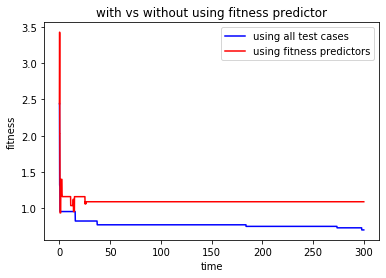

In [66]:
means1 = np.mean(ys1, axis=0)
means2 = np.mean(ys2, axis=0)
plt.plot(xs1, means1, color='blue', label='using all test cases')
plt.plot(xs2, means2, color='red', label='using fitness predictors')
plt.title('with vs without using fitness predictor')
plt.xlabel('time')
plt.ylabel('fitness')
plt.legend()
plt.show()


In [71]:
res1[0]['test_cases_evaluations'][-1]

42080700

In [72]:
res2[0]['test_cases_evaluations'][-1]

10226288

## this will be removed in the future

In [ ]:
# run gp on problems with parameters specified above
seed() # set seed here to reproduce same conditions
start = time.time()

for problem in problems:
    d = generate_dataset(problem['interval'], problem['func'])
    x = gp.GeneticProgram(d)
    fp_manager = gp.SLFitnessPredictorManager(x, d.shape[0])
    
    x_values = []
    used_predictors = []
    fitnesses = []
    best_ever_fitness = np.inf
    best_ever = None
    worse_solutions = []
    
    for i in range(runs):
        res = x.run_evolution(fp_manager=fp_manager, verbose=False)
        if res['best_of_run_exact_fitness'] < best_ever_fitness:
            best_ever_fitness = res['best_of_run_exact_fitness']
            best_ever = res['best']
    
        x_values.append(res['test_cases_evaluations'])
        used_predictors.append(res['used_predictors'])
        fitnesses.append(res['best_of_run_fitnesses'])
        worse_solutions.append(res['worse_solution'])
        
    
    # analyze situations where worse solution was prefered
    for i, sl in enumerate(worse_solutions):
        for j, s in enumerate(sl):
            # todo using res here doesnt make any sense at all and for this to work on multiple runs this has to be rewritten
            predictor_idx = np.where(x_values[i] == s)[0][0]
            plt.scatter(np.ones_like(used_predictors[i][0])*-1, used_predictors[i][predictor_idx - 1])
            plt.scatter(np.ones_like(used_predictors[i][0]), used_predictors[i][predictor_idx])
            plt.title(f'run: {i} change between {x_values[i][predictor_idx - 1]} -> {x_values[i][predictor_idx]}\n solution with {fitnesses[i][predictor_idx]} was prefered to {fitnesses[i][predictor_idx - 1]}')
            plt.savefig(f'{i}_{j}_0')
            plt.clf()
            plt.subplot(121)
            plt.title('previous')
            pl.target_with_predictor(d, res['best_solutions'][predictor_idx - 1],used_predictors[i][predictor_idx - 1])
            plt.subplot(122)
            plt.title('new')
            pl.target_with_predictor(d, res['best_solutions'][predictor_idx],used_predictors[i][predictor_idx])
            #print(x.fitness(res['best_solutions'][predictor_idx-1]), x.fitness(res['best_solutions'][predictor_idx]))
            
            plt.savefig(f'{i}_{j}_1')
            plt.clf()
    
    # select widest range
    x_values = x_values[np.argmax([len(v) for v in x_values])]
    
    # fill shorter runs with last values (in case some run converged or something...)
    for i in range(len(fitnesses)):
        while len(used_predictors[i]) < len(x_values): 
            used_predictors[i] = np.vstack([used_predictors[i], used_predictors[i][-1]])
        while len(fitnesses[i]) < len(x_values):
            fitnesses[i] = np.append(fitnesses[i], fitnesses[i][-1])
    
    # samples to use 
    idxs = np.linspace(0, len(x_values)-1, 15, dtype=np.int32)

    used_predictors = np.concatenate(used_predictors)
    

    #used_predictors = np.concatenate(used_predictors).flatten()
    used_predictors = d[:, 0][used_predictors.flatten()]
    fitnesses = np.vstack(fitnesses)
    
    # plot histogram
    vals, bins = np.histogram(used_predictors, bins=d.shape[0])
    # make bins same size as graph of the function
    vals = vals * ((max(d[:, 1]) - min(d[:, 1])) / max(vals))
    plt.bar(bins[:-1], vals, bottom=min(d[:, 1]), align='edge', alpha=0.75, width=(d[-1, 0]-d[0, 0]) / len(vals))
    plt.plot(d[:, 0], d[:, 1], label='target function')
    plt.title('histogram of used test cases')
    plt.legend()
    plt.show()
    

    #plot fitness
    avg_fitnesses = np.mean(fitnesses, axis=0)
    errors = np.std(fitnesses, axis=0)
    plt.errorbar(x_values[idxs], avg_fitnesses[idxs], yerr=errors[idxs], capsize=7)
    
    #for s in worse_solutions:
    #    for ss in s:
    #        plt.axvline(x=ss, ymin=0, ymax=max(avg_fitnesses), color='r', linestyle='dashed')
    plt.title('exact fitness of best solution averaged over runs')
    plt.show()

    print(f'best solution of the run:')
    pl.plot_solution_and_target(best_ever, problem['name'] , d)
    end = time.time()
    print(f'execution time: {end - start}')